In [131]:
import numpy as np
import sys
import pandas as pd
#from tensorflow import tf
from tensorflow.keras import  layers
from tensorflow.keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise, GaussianDropout
from keras.layers import Embedding, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import LSTM, Bidirectional
from matplotlib import pyplot as plt

In [132]:
import time
from ast import literal_eval
from operator import add
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from sklearn.utils import resample
plt.style.use('fivethirtyeight')
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import Dropout, Dense, Embedding, LSTM, SpatialDropout1D, Input, MaxPooling1D, Flatten, GRU, Conv2D, Reshape, MaxPool2D, Concatenate, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import concatenate
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
from keras.callbacks import ModelCheckpoint
import os
import gc
import csv
from keras.layers import LeakyReLU
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU,  BatchNormalization
from tensorflow.keras.layers import GRU, LSTM
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, TimeDistributed
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.layers import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
use_gpu=True
from keras import backend as K
import keras.initializers
import keras.regularizers
import keras.constraints
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
from numpy import dstack
import tensorflow as tf
from keras.layers.core import Lambda
import pickle
import random

In [133]:
path = '/home/hanping/remote file/MFB/'

In [134]:
FREQ_DIST_FILE = '/home/hanping/remote file/MFB/dataset/text/news-processed-freqdist.pkl'
BI_FREQ_DIST_FILE = '/home/hanping/remote file/MFB/dataset/text/news-processed-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE =  '/home/hanping/remote file/MFB/dataset/text/news_train.csv'
TEST_PROCESSED_FILE = '/home/hanping/remote file/MFB/dataset/text/news_test.csv'
GLOVE_FILE =  '/home/hanping/remote file/MFB/glove.twitter.27B.200d.txt'
dim = 200

In [135]:
def write_status(i, total):
    ''' Writes status of a process to console '''
    sys.stdout.write('\r')
    sys.stdout.write('Processing %d/%d' % (i, total))
    sys.stdout.flush()

In [136]:
def top_n_words(pkl_file_name, N, shift=0):
    with open(pkl_file_name, 'rb') as pkl_file:
        freq_dist = pickle.load(pkl_file)
    most_common = freq_dist.most_common(N)
    words = {p[0]: i + shift for i, p in enumerate(most_common)}
    return words

In [137]:
def get_glove_vectors(vocab):
    """
    Extracts glove vectors from seed file only for words present in vocab.
    """
    print ('Looking for GLOVE seeds')
    glove_vectors = {}
    found = 0
    with open(GLOVE_FILE, 'r',encoding='utf-8') as glove_file:
        for i, line in enumerate(glove_file):
            write_status(i + 1, 0)
            tokens = line.strip().split()
            word = tokens[0]
            if vocab.get(word):
                vector = [float(e) for e in tokens[1:]]
                glove_vectors[word] = np.array(vector)
                found += 1
    print ('\n')
    return glove_vectors

In [138]:
def get_feature_vector(tweet):
    """
    Generates a feature vector for each tweet where each word is
    represented by integer index based on rank in vocabulary.
    """
    words = tweet.split()
    feature_vector = []
    for i in range(len(words) - 1):
        word = words[i]
        if vocab.get(word) is not None:
            feature_vector.append(vocab.get(word))
    if len(words) >= 1:
        if vocab.get(words[-1]) is not None:
            feature_vector.append(vocab.get(words[-1]))
    return feature_vector

In [139]:
def process_tweets(csv_file, test_file=True):
    """
    Generates training X, y pairs.
    """
    tweets = []
    labels = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, sentiment, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append(feature_vector)
                labels.append(int(sentiment))
            else:
                tweets.append(feature_vector)
                labels.append(int(sentiment))
            write_status(i + 1, total)
    print ('\n')
    return tweets, np.array(labels)

In [140]:
#train = len(sys.argv) == 1
np.random.seed(1337)
vocab_size = 90000
batch_size = 1000
max_length = 40
filters = 600
kernel_size = 3
vocab = top_n_words(FREQ_DIST_FILE, vocab_size, shift=1)

In [141]:
glove_vectors = get_glove_vectors(vocab)
tweets, labels = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
embedding_matrix = np.random.randn(vocab_size + 1, dim) * 0.01
# Seed it with GloVe vectors
for word, i in vocab.items():
    glove_vector = glove_vectors.get(word)
    if glove_vector is not None:
        embedding_matrix[i] = glove_vector
tweets = pad_sequences(tweets, maxlen=max_length, padding='post')
shuffled_indices = np.random.permutation(tweets.shape[0])
tweets = tweets[shuffled_indices]
labels = labels[shuffled_indices]

Looking for GLOVE seeds
Processing 2935/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 8432/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 13970/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 19435/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 25065/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 30636/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 35839/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 47797/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 53940/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 60026/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 65940/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 72063/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 77974/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 84112/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 90038/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 95731/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 101966/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 107961/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 113728/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 119773/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 125686/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 131839/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 137674/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 143838/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 149858/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 155848/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 161863/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 167868/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 173875/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 179942/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 185853/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 192236/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 198154/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 204425/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 210460/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 216669/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 222668/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 228556/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 234558/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 240800/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 246789/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 252816/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 258730/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 264065/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 270121/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 275904/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 282067/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 288195/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 294277/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 300319/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 306332/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 312381/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 318352/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 323858/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 329824/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 335805/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 341829/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 347879/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 353935/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 359983/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 365834/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 372024/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 378006/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 384193/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 390281/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 395979/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 402102/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 407870/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 414201/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 420239/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 426224/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 432058/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 438146/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 444152/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 449898/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 456220/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 462379/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 468490/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 474485/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 480482/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 486501/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 492488/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 498509/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 504423/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 510145/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 516114/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 522190/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 528243/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 534242/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 540329/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 546320/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 552676/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 558646/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 564874/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 570760/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 576848/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 582485/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 588648/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 594626/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 600894/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 606913/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 612919/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 618906/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 624777/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 631047/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 637432/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 643546/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 649351/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 655534/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 661586/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 667635/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 673687/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 679701/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 685607/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 691648/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 697709/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 703669/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 709646/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 715471/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 721706/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 727885/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 733958/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 739899/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 746093/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 752293/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 758314/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 764280/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 770597/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 776748/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 782795/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 788446/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 794508/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 800542/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 806526/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 812456/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 818598/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 824627/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 830259/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 836217/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 842155/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 848434/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 854451/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 860380/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 866397/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 872451/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 878606/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 884729/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 890452/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 896616/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 902409/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 908159/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 914329/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 920380/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 926346/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 932312/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 938398/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 944062/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 950350/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 956321/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 962357/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 968436/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 974448/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 980351/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 986682/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 992811/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 998944/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1004887/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1010925/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1016839/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1023117/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1028913/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1035139/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1041163/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1047057/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1053123/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1059348/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1065407/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1071346/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1077415/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1083555/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1089619/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1095664/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1101622/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1107622/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1113642/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1119708/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1125615/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1131730/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1137600/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1143631/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1149310/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1155430/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1161149/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1166859/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1172788/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1179043/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1184969/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1190498/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 1193517/0

Generating feature vectors
Processing 1645/1645



In [142]:
def dot_product(x, kernel):
  if K.backend() == 'tensorflow':
      return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
  else:
      return K.dot(x, kernel)

from keras.layers import Layer

class AttentionWithContext(keras.layers.Layer):

    def __init__(self,
                W_regularizer=None, u_regularizer=None, b_regularizer=None,
                W_constraint=None, u_constraint=None, b_constraint=None,
                bias=True, **kwargs):

        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.u_regularizer = keras.regularizers.get(u_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.u_constraint = keras.constraints.get(u_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                initializer=self.init,
                                name='{}_W'.format(self.name),
                                regularizer=self.W_regularizer,
                                constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                    initializer='zero',
                                    name='{}_b'.format(self.name),
                                    regularizer=self.b_regularizer,
                                    constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                initializer=self.init,
                                name='{}_u'.format(self.name),
                                regularizer=self.u_regularizer,
                                constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def createHierarchicalAttentionModel(maxSeq, embWeights=None, embeddingSize = None, vocabSize = None,wordRnnSize=100, sentenceRnnSize=100,dropWordEmb = 0.2, dropWordRnnOut = 0.2, dropSentenceRnnOut = 0.5):
    '''
    maxSeq: maximum size for sentences
    '''
    # Sentence level logic
    wordInp = Input(shape=(maxSeq,),dtype='int32')
    if embWeights is None:
      x = Embedding(vocabSize, embeddingSize, input_length=maxSeq,trainable=True)(wordInp)
    else:
      x = Embedding(embWeights.shape[0], embWeights.shape[1], weights=[embWeights], trainable=False)(wordInp)

    # if dropWordEmb!=0.0:
    # 	x = Dropout(dropWordEmb)(x)
    wordRNN = Bidirectional(GRU(wordRnnSize,return_sequences=True))(x)
    # if dropWordRnnOut>0.0:
    # 	wordRNN = Dropout(dropWordRnnOut)(wordRNN)
    word_dense = TimeDistributed(Dense(200))(wordRNN)
    word_attention = AttentionWithContext()(word_dense)
    modelSentEncoder = Model(wordInp,word_attention)


    # Document level logic
    docInp = Input(shape=(1,maxSeq),dtype='int32')
    sentEncoder = TimeDistributed(modelSentEncoder)(docInp)
    sentRNN = Bidirectional(GRU(sentenceRnnSize,return_sequences=True))(sentEncoder)
    # if dropSentenceRnnOut!=0:
    # 	sentRNN = Dropout(dropSentenceRnnOut)(sentRNN)
    sent_dense = TimeDistributed(Dense(200))(sentRNN)
    sent_attention = AttentionWithContext()(sent_dense)
    docOut = Dense(1,activation='sigmoid')(sent_attention)
    model = Model(input=docInp,output=docOut)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    plot_model(model, show_shapes=True, to_file=path+'result/afghan_model_news.png')
    return model

In [143]:
embedding_dim = 200

def build_FGM(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = path + "result/our_model_news.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1,
                                  save_best_only = True, mode = "max")
    #early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 5)
   
    
    inp = Input(shape = (tweets.shape[1],), name = 'our-inp')
    embd1 = Embedding(embedding_matrix.shape[0], dim, weights = [embedding_matrix], trainable =True, name = 'our-embd_1')(inp)
    embd2 = Embedding(embedding_matrix.shape[0], dim, weights = [embedding_matrix], trainable = False, name = 'our-embd_2')(inp)
    first=GaussianNoise(0.2)(embd1)
    second=GaussianNoise(0.2)(embd2)
    x1 = SpatialDropout1D(spatial_dr, name = 'our-spdrop_1')(first)
    
    x4 = SpatialDropout1D(spatial_dr, name = 'our-spdrop_2')(second)
    
    x1_cnn = Conv1D(conv_size, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x1)
    max_pool1_cnn = MaxPooling1D(pool_size=2)(x1_cnn)

    x2_cnn = Conv1D(conv_size, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x1)

    max_pool2_cnn = MaxPooling1D(pool_size=2)(x2_cnn)

    x1_cnn_c = concatenate([max_pool1_cnn, max_pool2_cnn])#, x1])
    x_lstm1 = Bidirectional(LSTM(units, return_sequences = True))(x1_cnn_c)
    x_lstm11 = Dropout(dr)(x_lstm1)
    x_lstm111 = AttentionWithContext()(x_lstm11)


    x3_cnn = Conv1D(conv_size, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x4)

    max_pool3_cnn = MaxPooling1D(pool_size=2)(x3_cnn)

    x4_cnn = Conv1D(conv_size, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x4)

    max_pool4_cnn = MaxPooling1D(pool_size=2)(x4_cnn)

    x2_cnn_c = concatenate([max_pool3_cnn, max_pool4_cnn])#, x1])
    x_gru2 = Bidirectional(GRU(units, return_sequences = True))(x2_cnn_c)
    x_gru22 = Dropout(dr)(x_gru2)
    x_gru222 = AttentionWithContext()(x_gru22)


    x = concatenate([x_gru222, x_lstm111])#, x1])
    x = BatchNormalization()(x)
   
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(x)
    x = Dense(int(dense_units / 2), activation='relu') (x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])

    
    
    print(model.summary())
    plot_model(model, show_shapes=True, to_file= path + 'result/our_model_news.png')
    history = model.fit(tweets, labels, batch_size = 128, epochs = 50,  validation_split=0.15, 
                        verbose = 1, callbacks = [check_point])
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = path+'result/our_model_result_news.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    return model

In [ ]:
max_len = 40
model = build_FGM(lr = 1e-3, lr_d = 1e-10, units = 128, spatial_dr = 0.5, kernel_size1=2, kernel_size2=3, dense_units=32, dr=0.2, conv_size=32)

In [145]:
SEED = 2000

pathfile = '/home/hanping/remote file/MFB/dataset/text/news_processed_data.csv'
csv = pathfile
cols = ['id','sentiment','text']

my_df = pd.read_csv(csv, header = None, names = cols, encoding = 'latin-1')
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
x = my_df.text
y = my_df.sentiment

In [146]:
sentences_train = my_df['text'].values
y_train = my_df['sentiment'].values

In [147]:
tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(sentences_train)

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 200
embedding_matrix = create_embedding_matrix('/home/hanping/remote file/MFB/glove.twitter.27B.200d.txt',tokenizer.word_index, embedding_dim)

In [148]:
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))


Train set has total 1462 entries with 25.51% negative, 74.49% positive
Validation set has total 183 entries with 33.33% negative, 66.67% positive
Test set has total 183 entries with 22.40% negative, 77.60% positive


In [149]:
tvec = TfidfVectorizer(max_features=200000,ngram_range=(1, 3))
tvec.fit(x_train)

print('TFiDF fitted!')
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)
print('Logistic regression fitted!')

TFiDF fitted!
Logistic regression fitted!


In [150]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(x_train)

print('tokenizer fitted!')
sequences = tokenizer.texts_to_sequences(x_train)

x_train_seq = pad_sequences(sequences, maxlen= 40)
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen= 40)


tokenizer fitted!


In [151]:
x_test_new,y_test_new = process_tweets(TEST_PROCESSED_FILE, test_file=True)
x_test_new = pad_sequences(x_test_new, maxlen=max_length, padding='post')

Generating feature vectors
Processing 184/184



In [ ]:
embedding_dim = 200
max_len = 40
file_path = path+"result/news/CNN-Appdata.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1,
                              save_best_only = True, mode = "max")
early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 5)
m_name = 'CNN_App_'
inp = Input(shape = (max_len,), name = m_name+'inp')
embd = Embedding(embedding_matrix.shape[0], embedding_dim, weights = [embedding_matrix], trainable = True, name = 'our-embd_1')(inp)

conv1 = layers.Conv1D(filters=64, kernel_size=4, activation='relu',name=m_name+'conv_1')(embd)
pool1 = layers.GlobalMaxPooling1D(name=m_name+'pool_1')(conv1)

dense1 = Dense(64, activation='relu',name=m_name+'dense')(pool1)
x = Dense(1, activation = "sigmoid",name=m_name+'out')(dense1)
model = Model(inputs = inp, outputs = x)
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])


print(model.summary())
plot_model(model, show_shapes=True, to_file= path+"result/news/CNN-Appdata.png")
history = model.fit(x_train_seq, y_train, batch_size = 128, epochs = 50,  validation_data=(x_val_seq, y_validation), 
                    verbose = 1, callbacks = [check_point, early_stop])

In [154]:
embedding_dim = 200
def ABCDM(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = path + "result/news/ABCDM_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1,
                                  save_best_only = True, mode = "max")
    early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 5)
   
    
    inp = Input(shape = (max_len,), name = 'our-inp')
    embd1 = Embedding(embedding_matrix.shape[0], embedding_dim, weights = [embedding_matrix], trainable =True, name = 'our-embd_1')(inp)
    embd2 = Embedding(embedding_matrix.shape[0], embedding_dim, weights = [embedding_matrix], trainable = False, name = 'our-embd_2')(inp)
    
    #embedding_matrix_glove
    #embd = concatenate([embd1,embd2])
    #x1 = SpatialDropout1D(spatial_dr, name = 'our-spdrop_1')(embd)
    x1 = SpatialDropout1D(spatial_dr, name = 'our-spdrop_1')(embd1)
    
    x4 = SpatialDropout1D(spatial_dr, name = 'our-spdrop_2')(embd2)
    
    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_gru = Dropout(dr)(x_gru)
    x = AttentionWithContext()(x_gru)
    
    #############################################
    x = Lambda(lambda t: tf.expand_dims(t, 2))(x)
    #############################################
    
    x2 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x)
    avg_pool1_gru = GlobalAveragePooling1D()(x2)
    max_pool1_gru = GlobalMaxPooling1D()(x2)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    #x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x4)
    
    x_lstm = Dropout(dr)(x_lstm)
    x = AttentionWithContext()(x_lstm)
    
    #############################################
    x = Lambda(lambda t: tf.expand_dims(t, 2))(x)
    #############################################
    
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)

    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru, avg_pool1_lstm, max_pool1_lstm,avg_pool3_lstm,max_pool3_lstm])#, x1])
    x = BatchNormalization()(x)
   
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(x)
    x = Dense(int(dense_units / 2), activation='relu') (x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
   # model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
    
    print(model.summary())
    plot_model(model, show_shapes=True, to_file= path + 'result/news/ABCDM_model.png')
    history = model.fit(x_train_seq, y_train, batch_size = 256, epochs = 50,  validation_data=(x_val_seq, y_validation),
                        verbose = 1, callbacks = [check_point, early_stop])
    return model

In [ ]:
max_len = 40
model = ABCDM(lr = 1e-3, lr_d = 1e-10, units = 128, spatial_dr =  0.5, kernel_size1 = 4, kernel_size2 = 6, dense_units = 64, dr = 0.2, conv_size = 32)#conv_size=32

In [ ]:
file_path = path+"result/news/AC-BiLSTM.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1,
                              save_best_only = True, mode = "max")
tweet_input = Input(shape = (max_len,), dtype='int32', name = 'AC-BiLSTM_inp')
tweet_encoder = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False,name = 'AC-BiLSTM_enc')(tweet_input)
x = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu',name = 'AC-BiLSTM_conv')(tweet_encoder)
x = Bidirectional(LSTM(64, return_sequences=True,name= 'AC-BiLSTM_BiLSTM'))(x)
x = Dropout(0.7,name = 'AC-BiLSTM_drop')(x)
x = AttentionWithContext()(x)
x = Dense(1,name = 'AC-BiLSTM_out')(x)
output = Activation('sigmoid')(x)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, show_shapes=True, to_file= path+"result/news/AC-BiLSTM.png")
model.summary()

early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 3)

history = model.fit(x_train_seq, y_train, batch_size = 128, epochs = 50,  validation_data=(x_val_seq, y_validation), 
                    verbose = 1, callbacks = [check_point, early_stop])

In [ ]:
file_path2 = path+"result/news/T-BCNN.hdf5"
tweet_input = Input(shape=(x_train_seq.shape[1],), dtype='int32', name = 'T-BCNN_inp')
tweet_encoder = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False,name = 'T-BCNN_enc')(tweet_input)
embedding = Dropout(0.50)(tweet_encoder)

c1 = Conv1D(filters=200, kernel_size=4, padding='valid', activation='relu',name = 'T-BCNN_conv_1')(embedding)
p1 = MaxPooling1D(pool_size=2,name='T-BCNN_pool_1')(c1)

c2 = Conv1D(filters=200, kernel_size=5, padding='valid', activation='relu',name = 'T-BCNN_conv_2')(embedding)
p2 = MaxPooling1D(pool_size=2,name='T-BCNN_pool_2')(c2)

merge = concatenate([p1, p2],axis=1, name='T-BCNN_concat')
drop = Dropout(0.15,name='T-BCNN_drop_1')(merge)

rnn = GRU(units = 100, name = 'T-BCNN_GRU')(drop)
x = Dense(400, activation="relu",name='T-BCNN_dense')(rnn)
drop = Dropout(0.1, name = 'T-BCNN_drop_2')(x)
x = Dense(1,name = 'T-BCNN_out')(x)
output = Activation('sigmoid')(x)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(model, show_shapes=True, to_file= path+"result/news/T-BCNN.png")
model.summary()

check_point = ModelCheckpoint(file_path2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 3)

history = model.fit(x_train_seq, y_train, batch_size = 128, epochs = 50,  validation_data=(x_val_seq, y_validation), 
                    verbose = 1, callbacks = [check_point, early_stop])

print(model.summary())

In [ ]:
file_path = path+"result/news/ARC_BiGRU.hdf5"
tweet_input = Input(shape=(x_train_seq.shape[1],), dtype='int32', name = 'AC-ARC_BiGRU')
tweet_encoder = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False,name = 'ARC_enc')(tweet_input)

x1 = SpatialDropout1D(0.5)(tweet_encoder)
x_gru = Bidirectional(GRU(64, return_sequences = True,name= 'ARC_BiGRU'))(x1)
x = AttentionWithContext()(x_gru)


x = Lambda(lambda t: tf.expand_dims(t, 2))(x)

x2 = Conv1D(100, kernel_size=3, padding='valid', kernel_initializer='he_uniform', name= 'ARC_CNN_1')(x)
x2 = Conv1D(100, kernel_size=5, padding='valid', kernel_initializer='he_uniform', name= 'ARC_CNN_2')(x2)
x2 = Conv1D(100, kernel_size=7, padding='valid', kernel_initializer='he_uniform', name= 'ARC_CNN_3')(x2)

max_pool1 = GlobalMaxPooling1D(name= 'ARC_pool')(x2)
x5 = Dense(64, activation="relu",name='ARC_dense')(max_pool1)
output = Dense(1,activation='sigmoid')(x5)

model = Model(inputs=tweet_input, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, show_shapes=True, to_file= path+"result/news/ARC_BiGRU.png")
model.summary()

check_point = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 3)

history = model.fit(x_train_seq, y_train, batch_size = 128, epochs = 50,  validation_data=(x_val_seq, y_validation), 
                    verbose = 1, callbacks = [check_point, early_stop])

In [ ]:
embedding_dim = 200
max_len = 40
file_path = path + "result/news/GloveRNNCNN.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1,
                              save_best_only = True, mode = "max")
early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 5)
m_name = 'GloveRNNCNN'
inp = Input(shape = (max_len,), name = m_name+'inp')
embd = Embedding(embedding_matrix.shape[0], embedding_dim, weights = [embedding_matrix], trainable = True, name = 'our-embd_1')(inp)
x1 = SpatialDropout1D(0.5, name = 'our-spdrop_1')(embd)


x_gru = Bidirectional(LSTM(32, return_sequences = True))(x1)
x_gru = Dropout(0.2)(x_gru)

conv1 = layers.Conv1D(filters=64, kernel_size=4, activation='relu',name=m_name+'conv_1')(x_gru)
pool1 = layers.GlobalMaxPooling1D(name=m_name+'pool_1')(conv1)

dense1 = Dense(64, activation='relu',name=m_name+'dense')(pool1)
x = Dense(1, activation = "sigmoid",name=m_name+'out')(dense1)
model = Model(inputs = inp, outputs = x)
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])


print(model.summary())
plot_model(model, show_shapes=True, to_file= path + "result/news/GloveRNNCNN.png")
history = model.fit(x_train_seq, y_train, batch_size = 128, epochs = 50,  validation_data=(x_val_seq, y_validation), 
                    verbose = 1, callbacks = [check_point, early_stop])

In [ ]:
embedding_dim = 200
max_len = 40
file_path = path + "result/news/ACR-SA.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1,
                              save_best_only = True, mode = "max")
early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 5)
m_name = 'ACR-SA'
inp = Input(shape = (max_len,), name = m_name+'inp')
embd = Embedding(embedding_matrix.shape[0], embedding_dim, weights = [embedding_matrix], trainable = True, name = 'our-embd_1')(inp)
first=GaussianNoise(0.2)(embd)
x1 = SpatialDropout1D(0.5, name = 'our-spdrop_1')(first)

x_gru = Bidirectional(GRU(32, return_sequences = True))(x1)
x_gru = Dropout(0.2)(x_gru)

conv1 = layers.Conv1D(filters=64, kernel_size=4, activation='relu',name=m_name+'conv_1')(x_gru)
pool1 = layers.GlobalMaxPooling1D(name=m_name+'pool_1')(conv1)

dense1 = Dense(64, activation='relu',name=m_name+'dense')(pool1)
x = Dense(1, activation = "sigmoid",name=m_name+'out')(dense1)
model = Model(inputs = inp, outputs = x)
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])


print(model.summary())
plot_model(model, show_shapes=True, to_file= path + 'result/news/ACR-SA.png')
history = model.fit(x_train_seq, y_train, batch_size = 128, epochs = 50,  validation_data=(x_val_seq, y_validation), 
                    verbose = 1, callbacks = [check_point, early_stop])

In [ ]:
path = '/home/hanping/remote file/MFB/result/news/'
max_len = 40
dataset_name = 'news'

loaded_our_model1 = load_model('/home/hanping/remote file/MFB/result/our_model_news.hdf5', custom_objects={'AttentionWithContext': AttentionWithContext , "tf": tf})
print('Our model loaded')
loaded_ARC_model = load_model(path + 'ARC_BiGRU.hdf5', custom_objects={'AttentionWithContext': AttentionWithContext , "tf": tf})
print('ARC model loaded')
loaded_ABCDM_model = load_model(path + 'ABCDM_model.hdf5', custom_objects={'AttentionWithContext': AttentionWithContext})
print('ABCDM model loaded')
loaded_TBCNN_model = load_model(path  + 'T-BCNN.hdf5')
print('T-BCNN model loaded')

loaded_ACBiLSTM_model = load_model(path  + 'AC-BiLSTM.hdf5', custom_objects={'AttentionWithContext': AttentionWithContext})
print('AC-BiLSTM model loaded')

loaded_CNN_model = load_model(path  + 'CNN-Appdata.hdf5')
print('CNN model loaded')

loaded_acrsa_model = load_model(path  + 'ACR-SA.hdf5')
print('ACR-SA model loaded')
loaded_glovernn_model = load_model(path  + 'GloveRNNCNN.hdf5')
print('GloveRNNCNN model loaded')

In [ ]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

yhat_our1 = loaded_our_model1.predict(x_test_new)
print('our model complete!')

yhat_arc = loaded_ARC_model.predict(x_test_seq)
print('ARC model complete!')

################################################################################
x_test_seq_exp = np.expand_dims(x_test_seq, axis=1)
y_test_exp = np.expand_dims(y_test, axis=1)

yhat_abcdm = loaded_ABCDM_model.predict(x_test_seq)
print('ABCDM model complete!')
################################################################################

yhat_tbcnn = loaded_TBCNN_model.predict(x_test_seq)
print('T-BCNN model complete!')

yhat_acbilstm = loaded_ACBiLSTM_model.predict(x_test_seq)
print('ACBiLSTM model complete!')

yhat_cnn = loaded_CNN_model.predict(x_test_seq)
print('Glove-CNN model complete!')

yhat_acrsa = loaded_acrsa_model.predict(x_test_seq)
print('ACR-SA model complete!')

yhat_bilstm = loaded_glovernn_model.predict(x_test_seq)
print('Glove RNN CNN model complete!')

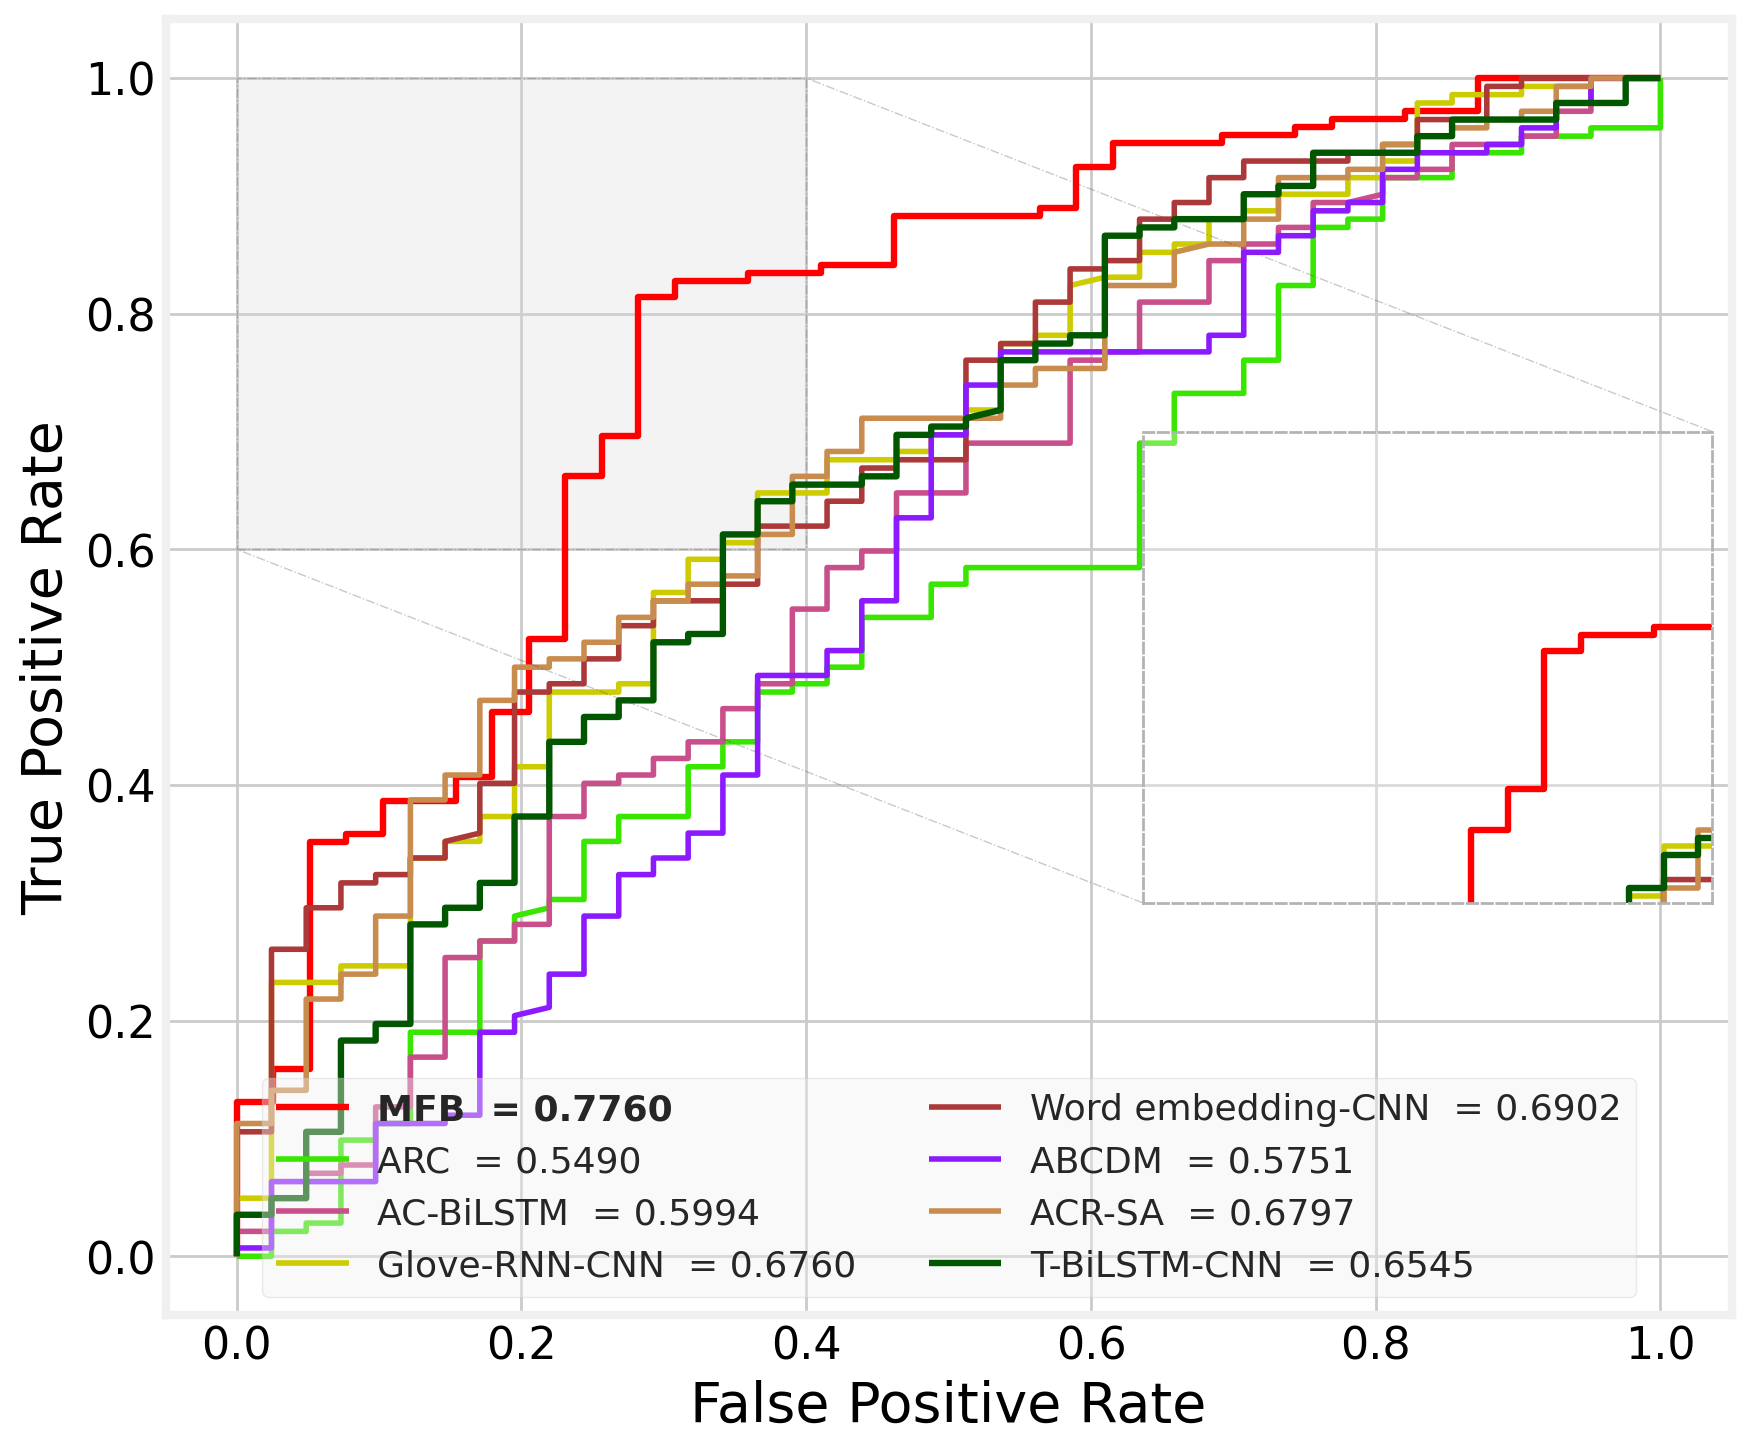

In [174]:
fpr_our4, tpr_our4, threshold4 = roc_curve(y_test_new, yhat_our1)
roc_auc_our4 = auc(fpr_our4, tpr_our4)
fpr_arc, tpr_arc, threshold = roc_curve(y_test, yhat_arc)
roc_auc_arc = auc(fpr_arc, tpr_arc)

fpr_abcdm, tpr_abcdm, threshold = roc_curve(y_test_exp, yhat_abcdm)
roc_auc_abcdm = auc(fpr_abcdm, tpr_abcdm)

fpr_acbilstm, tpr_acbilstm, threshold = roc_curve(y_test, yhat_acbilstm)
roc_auc_acbilstm = auc(fpr_acbilstm, tpr_acbilstm)

fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

fpr_acrsa, tpr_acrsa, threshold = roc_curve(y_test, yhat_acrsa)
roc_auc_acrsa = auc(fpr_acrsa, tpr_acrsa)

fpr_bilstm, tpr_bilstm, threshold = roc_curve(y_test, yhat_bilstm)
roc_auc_bilstm = auc(fpr_bilstm, tpr_bilstm)

fpr_tbcnn, tpr_tbcnn, threshold = roc_curve(y_test, yhat_tbcnn)
roc_auc_tbcnn = auc(fpr_tbcnn, tpr_tbcnn)
#################################3
fig = plt.figure(figsize=(9,8),dpi=200)
ax = fig.add_subplot(111)
plt.gcf().set_facecolor('white')
ax.plot(fpr_our4, tpr_our4, label='MFB  = %0.4f' % roc_auc_our4, linewidth=2.3, color = 'red')
#ax.plot(fpr_acl, tpr_acl, label='ACL  = %0.4f' % roc_auc_acl, linewidth=2.3, color = '#005700')
ax.plot(fpr_arc, tpr_arc, label='ARC  = %0.4f' % roc_auc_arc, linewidth=2, color = '#39e600')
ax.plot(fpr_acbilstm, tpr_acbilstm, label='AC-BiLSTM  = %0.4f' % roc_auc_acbilstm, linewidth=2, color = '#c94f8a')
ax.plot(fpr_bilstm, tpr_bilstm, label='Glove-RNN-CNN  = %0.4f' % roc_auc_bilstm, linewidth=2, color = '#cccc00')
ax.plot(fpr_cnn, tpr_cnn, label='Word embedding-CNN  = %0.4f' % roc_auc_cnn, linewidth=2, color = '#ac3939')
ax.plot(fpr_abcdm, tpr_abcdm, label='ABCDM  = %0.4f' % roc_auc_abcdm, linewidth=2, color = '#8c1aff')
ax.plot(fpr_acrsa, tpr_acrsa, label='ACR-SA  = %0.4f' % roc_auc_acrsa, linewidth=2, color = '#c98c4f')
ax.plot(fpr_tbcnn, tpr_tbcnn, label='T-BiLSTM-CNN  = %0.4f' % roc_auc_tbcnn, linewidth=2.3, color = '#005700')

ax.set_facecolor('white')
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.tick_params(labelsize=16)

ax.set_title('')
legend=ax.legend(loc='lower left',  ncol = 2,bbox_to_anchor=(0.05, 0.0, 0.0, 0.0),framealpha= 0.4, fontsize=13)
texts = legend.get_texts()
texts[0].set_weight('bold')

axins = zoomed_inset_axes(ax, 1, loc = 'center right')

axins.plot(fpr_our4, tpr_our4, label='MFB  = %0.4f' % roc_auc_our4, linewidth=2.3, color = 'red')
axins.plot(fpr_arc, tpr_arc, label='ARC  = %0.3f' % roc_auc_arc, linewidth=2, color = '#39e600')
axins.plot(fpr_acbilstm, tpr_acbilstm, label='AC-BiLSTM  = %0.3f' % roc_auc_acbilstm, linewidth=2, color = '#c94f8a')
axins.plot(fpr_bilstm, tpr_bilstm, label='Glove-RNN-CNN  = %0.4f' % roc_auc_bilstm, linewidth=2, color = '#cccc00')
axins.plot(fpr_cnn, tpr_cnn, label='Word embedding-CNN  = %0.3f' % roc_auc_cnn, linewidth=2, color = '#ac3939')
axins.plot(fpr_abcdm, tpr_abcdm, label='ABCDM = %0.3f' % roc_auc_abcdm, linewidth=2, color = '#8c1aff')
axins.plot(fpr_acrsa, tpr_acrsa, label='ACR-SA  = %0.4f' % roc_auc_acrsa, linewidth=2, color = '#c98c4f')
axins.plot(fpr_tbcnn, tpr_tbcnn, label='T-BiLSTM-CNN  = %0.4f' % roc_auc_tbcnn, linewidth=2.3, color = '#005700')


axins.patch.set_facecolor('white')
axins.patch.set_alpha(0.3)

axins.spines['bottom'].set_color('0.7')
axins.spines['bottom'].set_linewidth('1')
axins.spines['bottom'].set_linestyle('--')
axins.spines['top'].set_color('0.7')
axins.spines['top'].set_linewidth('1')
axins.spines['top'].set_linestyle('--')
axins.spines['right'].set_color('0.7')
axins.spines['right'].set_linewidth('1')
axins.spines['right'].set_linestyle('--')
axins.spines['left'].set_color('0.7')
axins.spines['left'].set_linewidth('1') 
axins.spines['left'].set_linestyle('--')  

x1, x2, y1, y2 = 0, 0.4, 0.6, 1 # specify the limits

axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.yticks(visible=False)
plt.xticks(visible=False)
plt.grid(visible=False)

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=1, loc2=3, fc="#d9d9d9", ec="0.3", alpha = 0.3, ls = '-.')

plt.savefig(path+ dataset_name + '-AUC710_PJ.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.1)


In [166]:
classifiers = [yhat_our1]
classifiers_name = ['negative -' ,'positive +']
dataset_name = 'news'

y_test_list = y_test_new.tolist()
results = []
for c,i in zip(classifiers,range(len(classifiers))):
  labels = (c > 0.5).astype(np.int)
  labels = labels.flatten().tolist()

  data = []
  cnf_matrix = confusion_matrix(y_test_list, labels)

  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)


  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP)
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)
  F1 = (2 * TPR * PPV)/(TPR + PPV)
  data.append(TPR)
  data.append(TNR)
  data.append(PPV)
  #data.append(NPV)
  #data.append(FPR)
  #data.append(FDR)
  data.append(F1)
  data.append(ACC)

  results.append([round(d[0],4) for d in data])
  results.append([round(d[1],4) for d in data])

print("\t Recall, Specifity, Precision, F1, Accuracy")
for r,name in zip(results,classifiers_name):
  print(name,': ',r)
with open(path+"Results_our_model_tweets.txt", "w") as filehandle:
    filehandle.writelines(f"{name} %s\n" %r for r,name in zip(results,classifiers_name))

	 Recall, Specifity, Precision, F1, Accuracy
negative - :  [0.2564, 0.9586, 0.625, 0.3636, 0.8098]
positive + :  [0.9586, 0.2564, 0.8274, 0.8882, 0.8098]


/home/hanping/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [171]:
classifiers = [yhat_acrsa]
classifiers_name = ['negative -' ,'positive +']
dataset_name = 'news'

y_test_list = y_test.tolist()
results = []
for c,i in zip(classifiers,range(len(classifiers))):
  labels = (c > 0.5).astype(np.int)
  labels = labels.flatten().tolist()

  data = []
  cnf_matrix = confusion_matrix(y_test_list, labels)

  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)


  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP)
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)
  F1 = (2 * TPR * PPV)/(TPR + PPV)
  data.append(TPR)
  data.append(TNR)
  data.append(PPV)
  #data.append(NPV)
  #data.append(FPR)
  #data.append(FDR)
  data.append(F1)
  data.append(ACC)

  results.append([round(d[0],4) for d in data])
  results.append([round(d[1],4) for d in data])

print("\t Recall, Specifity, Precision, F1, Accuracy")
for r,name in zip(results,classifiers_name):
  print(name,': ',r)
with open(path+"Results_our_model_tweets.txt", "w") as filehandle:
    filehandle.writelines(f"{name} %s\n" %r for r,name in zip(results,classifiers_name))

	 Recall, Specifity, Precision, F1, Accuracy
negative - :  [0.1463, 0.9577, 0.5, 0.2264, 0.776]
positive + :  [0.9577, 0.1463, 0.7953, 0.869, 0.776]


/home/hanping/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [172]:
classifiers = [yhat_bilstm]
classifiers_name = ['negative -' ,'positive +']
dataset_name = 'news'

y_test_list = y_test.tolist()
results = []
for c,i in zip(classifiers,range(len(classifiers))):
  labels = (c > 0.5).astype(np.int)
  labels = labels.flatten().tolist()

  data = []
  cnf_matrix = confusion_matrix(y_test_list, labels)

  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)


  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP)
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)
  F1 = (2 * TPR * PPV)/(TPR + PPV)
  data.append(TPR)
  data.append(TNR)
  data.append(PPV)
  #data.append(NPV)
  #data.append(FPR)
  #data.append(FDR)
  data.append(F1)
  data.append(ACC)

  results.append([round(d[0],4) for d in data])
  results.append([round(d[1],4) for d in data])

print("\t Recall, Specifity, Precision, F1, Accuracy")
for r,name in zip(results,classifiers_name):
  print(name,': ',r)
with open(path+"Results_our_model_tweets.txt", "w") as filehandle:
    filehandle.writelines(f"{name} %s\n" %r for r,name in zip(results,classifiers_name))

	 Recall, Specifity, Precision, F1, Accuracy
negative - :  [0.3659, 0.8521, 0.4167, 0.3896, 0.7432]
positive + :  [0.8521, 0.3659, 0.8231, 0.8374, 0.7432]


/home/hanping/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [173]:
classifiers = [yhat_tbcnn]
classifiers_name = ['negative -' ,'positive +']
dataset_name = 'news'

y_test_list = y_test.tolist()
results = []
for c,i in zip(classifiers,range(len(classifiers))):
  labels = (c > 0.5).astype(np.int)
  labels = labels.flatten().tolist()

  data = []
  cnf_matrix = confusion_matrix(y_test_list, labels)

  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)


  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP)
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)
  F1 = (2 * TPR * PPV)/(TPR + PPV)
  data.append(TPR)
  data.append(TNR)
  data.append(PPV)
  #data.append(NPV)
  #data.append(FPR)
  #data.append(FDR)
  data.append(F1)
  data.append(ACC)

  results.append([round(d[0],4) for d in data])
  results.append([round(d[1],4) for d in data])

print("\t Recall, Specifity, Precision, F1, Accuracy")
for r,name in zip(results,classifiers_name):
  print(name,': ',r)
with open(path+"Results_our_model_tweets.txt", "w") as filehandle:
    filehandle.writelines(f"{name} %s\n" %r for r,name in zip(results,classifiers_name))

	 Recall, Specifity, Precision, F1, Accuracy
negative - :  [0.122, 0.9648, 0.5, 0.1961, 0.776]
positive + :  [0.9648, 0.122, 0.7919, 0.8698, 0.776]


/home/hanping/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
